# Compas Analysis

In [6]:
!pip install pandas numpy matplotlib seaborn statsmodels -q

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

sns.set(style="whitegrid")

In [10]:
raw_data = pd.read_csv("dataset/compas-scores-two-years.csv")
print(f"Total rows number: {len(raw_data)}")

Total rows number: 7214


In [14]:
df = raw_data.loc[:, [
    'age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
    'priors_count', 'days_b_screening_arrest', 'decile_score',
    'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out'
]]

In [15]:
# We filter out rows for several reasons: (similar to the Propublica study)
# 1. Screening date not within ±30 days of arrest  
# 2. Missing recidivism flag (`is_recid == -1`)  
# 3. Non-jailable offenses (`c_charge_degree == 'O'`)  
# 4. Missing COMPAS score text (`score_text == 'N/A'`)  
# 5. Only individuals with either two-year recidivism or ≥2 years out of jail

In [16]:
df = df[
    df['days_b_screening_arrest'].between(-30, 30) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'] != 'O') &
    (df['score_text'] != 'N/A')
].copy()

print(f"Rows after filtering: {len(df)}")

Rows after filtering: 6172


In [18]:
#length of jail stay and its correlation with COMPAS decile score.

df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).dt.days

corr = df[['length_of_stay', 'decile_score']].corr().iloc[0,1]
print(f"Correlation between length_of_stay and decile_score: {corr:.4f}")


Correlation between length_of_stay and decile_score: 0.2075


After filtering we have the following demographic breakdown:

In [20]:
print(df['age_cat'].value_counts(dropna=False))

age_cat
25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: count, dtype: int64


In [21]:
print(df['race'].value_counts(dropna=False))

race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64


In [22]:
total = len(df)
for race, count in df['race'].value_counts().items():
    print(f"{race}: {count/total*100:.2f}%")

African-American: 51.44%
Caucasian: 34.07%
Hispanic: 8.25%
Other: 5.56%
Asian: 0.50%
Native American: 0.18%


In [23]:
print(df['score_text'].value_counts())

score_text
Low       3421
Medium    1607
High      1144
Name: count, dtype: int64


In [24]:
print(pd.crosstab(df['sex'], df['race']))

race    African-American  Asian  Caucasian  Hispanic  Native American  Other
sex                                                                         
Female               549      2        482        82                2     58
Male                2626     29       1621       427                9    285


In [25]:
sex_counts = df['sex'].value_counts()
for sex, count in sex_counts.items():
    print(f"{sex}: {count/total*100:.2f}%")

Male: 80.96%
Female: 19.04%


In [26]:
recid_count = df['two_year_recid'].sum()
print(f"\nNumber of recidivists: {recid_count}")
print(f"Recidivism rate: {recid_count/total*100:.2f}%")


Number of recidivists: 2809
Recidivism rate: 45.51%


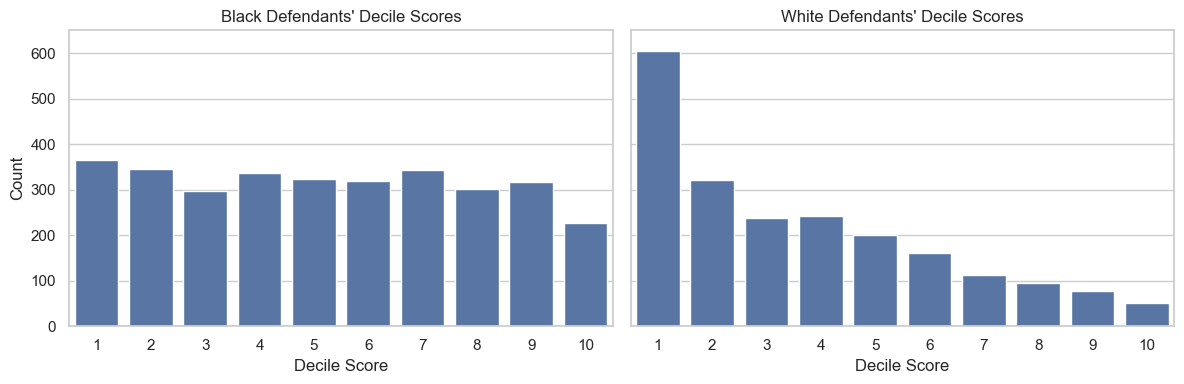

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.countplot(x='decile_score', data=df[df['race']=="African-American"],
              order=sorted(df['decile_score'].unique()),
              ax=axes[0])
axes[0].set_title("Black Defendants' Decile Scores")
axes[0].set_ylim(0, 650)

sns.countplot(x='decile_score', data=df[df['race']=="Caucasian"],
              order=sorted(df['decile_score'].unique()),
              ax=axes[1])
axes[1].set_title("White Defendants' Decile Scores")
axes[1].set_ylim(0, 650)

for ax in axes:
    ax.set_xlabel("Decile Score")
    ax.set_ylabel("Count")

plt.tight_layout()

In [32]:
pd.crosstab(df['decile_score'], df['race'])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


## Racial Bias in Compas

We run a logistic regression predicting High vs. Low COMPAS score (`score_text != 'Low'`) as a function of gender, age category, race, number of priors, charge degree, and recidivism.

In [33]:
df['high_score'] = (df['score_text'] != 'Low').astype(int)

In [37]:
model = smf.logit(
    formula="high_score ~ C(sex) + C(age_cat) + C(race) + priors_count + C(c_charge_degree) + two_year_recid",
    data=df
).fit(disp=False)

print(model.summary())

                           Logit Regression Results                           
Dep. Variable:             high_score   No. Observations:                 6172
Model:                          Logit   Df Residuals:                     6160
Method:                           MLE   Df Model:                           11
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.2729
Time:                        19:43:14   Log-Likelihood:                -3084.2
converged:                       True   LL-Null:                       -4241.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.8271      0.091     -9.132      0.000      -1.005      -0.650
C(sex)[T.Male]                   -0.2213      0.080     -2.783      0.005 

In [45]:
intercept      = model.params['Intercept']
beta_white     = model.params['C(race)[T.Caucasian]']
beta_male      = model.params['C(sex)[T.Male]']
beta_under25   = model.params['C(age_cat)[T.Less than 25]']

# baseline prob. for the reference group
p0 = np.exp(intercept) / (1 + np.exp(intercept))
print(f"Baseline P(high_score): {p0:.3f}")

# adj prob ratios
def adj_ratio(beta):
    num = np.exp(beta)
    return num / (1 - p0 + p0 * num)

print(f"White vs. Black ratio: {adj_ratio(beta_white):.3f}")
print(f"Male vs. Female ratio: {adj_ratio(beta_male):.3f}")
print(f"<25 vs. 25–45 ratio: {adj_ratio(beta_under25):.3f}")

Baseline P(high_score): 0.304
White vs. Black ratio: 0.702
Male vs. Female ratio: 0.853
<25 vs. 25–45 ratio: 2.031


- Baseline group (African-American female, age 25–45, no priors, no two-year recidivism) has a 30.4 % chance of being labeled “High Risk.”
- White vs. Black: White defendants are only 0.702 × as likely as Black defendants to receive a High score — about a 29.8 % lower probability.
- Male vs. Female: Male defendants are 0.853 × as likely as female defendants to get a - High score — roughly a 14.7 % lower probability.
- Under 25 vs. 25–45: Defendants under 25 are about 2.03 × as likely as 25–45-year-olds to be classified High Risk.